In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

COINS = ['btc', 'eth']
DATA_DIR = '/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/snapshot_data'

In [10]:
import os
import pandas as pd
import numpy as np

for coin in COINS:
    full_path = os.path.join(DATA_DIR, f'{coin}_full_data_transformed.csv')
    df = pd.read_csv(full_path)

    # ── Basic cleaning ─────────────────────────
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df[['coin', 'exp_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)
    df['coin'] = df['coin'].str.lower()
    df = df[df['coin'] == coin]

    df['date'] = df['timestamp'].dt.date
    num_days = df['date'].nunique()

    # ── Parse expiry and compute DTE ───────────
    df['expiry'] = pd.to_datetime(df['exp_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)
    df['expiry'] = df['expiry'].dt.tz_localize('UTC')
    df['DTE'] = np.floor((df['expiry'] - df['timestamp']) / pd.Timedelta(days=1)).astype('Int64')

    # ── Count total unique contracts ───────────
    all_unique = df['symbol'].nunique()

    # ── Count unique 0DTE contracts ────────────
    avg_daily_0dte = (df[df['DTE']==0]
                  .groupby(df['timestamp'].dt.floor('D'))['symbol']
                  .nunique()
                  .mean())


    print(f"{coin.upper()} — Total unique contracts: {all_unique} on {num_days} days with on average {avg_daily_0dte:.2f} 0DTE contracts per day")

BTC — Total unique contracts: 13658 on 365 days with on average 70.19 0DTE contracts per day
ETH — Total unique contracts: 15952 on 365 days with on average 82.17 0DTE contracts per day


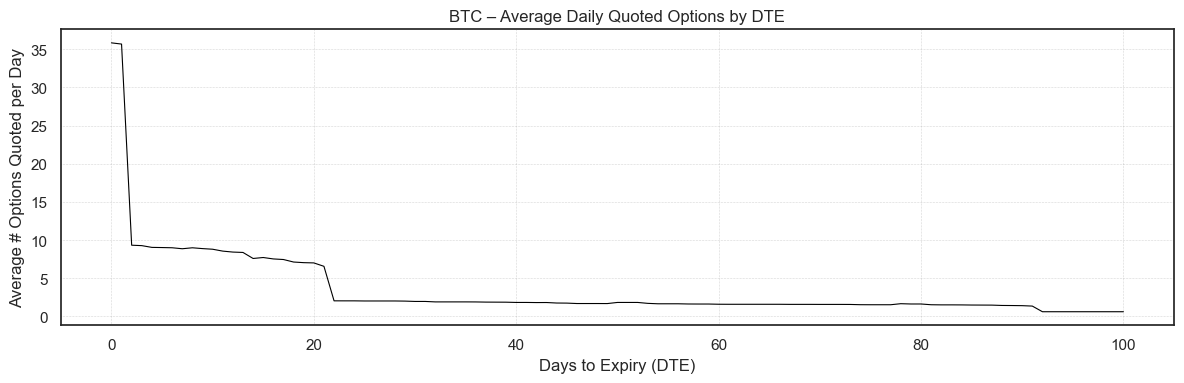

Unique Quoted DTEs for BTC: 372
Amount of 0DTE Options Quoted for BTC: 13080
Fraction of 0DTE Options Quoted for BTC: 7.23%
Average Daily Unique Quoted Options for BTC: 495.56
Average Daily Unique Quoted Options for 0DTE BTC: 35.84


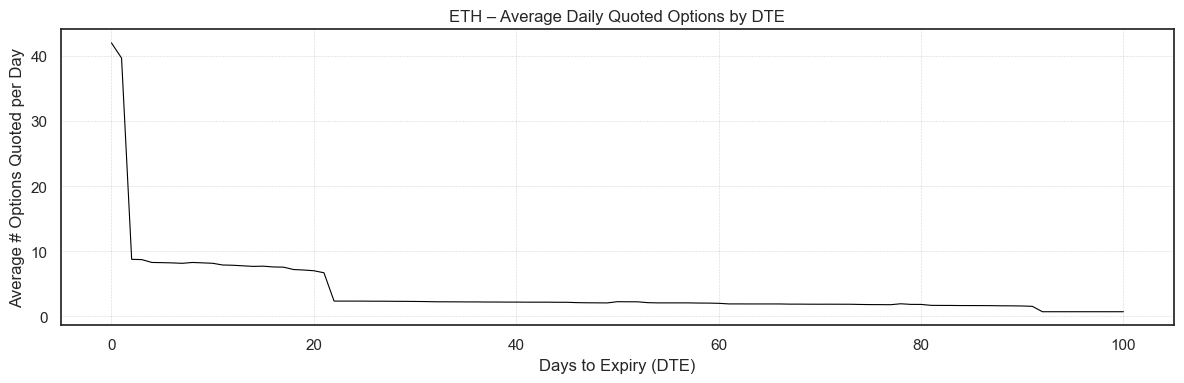

Unique Quoted DTEs for ETH: 372
Amount of 0DTE Options Quoted for ETH: 15327
Fraction of 0DTE Options Quoted for ETH: 7.95%
Average Daily Unique Quoted Options for ETH: 528.00
Average Daily Unique Quoted Options for 0DTE ETH: 41.99


In [23]:
for coin in COINS:
    full_path = os.path.join(DATA_DIR, f'{coin}_full_data_transformed.csv')

    df = pd.read_csv(full_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)   
    df['date'] = df['timestamp'].dt.date                          # extract the date
    unique_days = df['date'].nunique()   
    df[['coin', 'exp_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)              

    expiry_date = pd.to_datetime(df['exp_raw'], format='%d%b%y', errors='coerce')
    df['expiry'] = (expiry_date + pd.Timedelta(hours=8)).dt.tz_localize('UTC')     
    df['DTE'] = np.floor((df['expiry'] - df['timestamp']) / pd.Timedelta(days=1)).astype('Int64')    
    df = df[df['DTE'] >= 0].dropna(subset=['DTE'])   

    # Count unique quoted option symbols per DTE
    dte_counts = df.groupby('DTE')['symbol'].nunique().sort_index()
    
    # Average the amount of options quoted per DTE over the unique days
    average_dte_counts = dte_counts / unique_days
    average_dte_counts_adj = average_dte_counts[average_dte_counts.index <= 100]

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(average_dte_counts_adj.index, average_dte_counts_adj.values,
            color='black', linewidth=0.8, markersize=3, label='Avg Daily Unique Symbols')
    plt.title(f'{coin.upper()} – Average Daily Quoted Options by DTE')
    plt.xlabel('Days to Expiry (DTE)')
    plt.ylabel('Average # Options Quoted per Day')
    plt.grid(ls=':', lw=0.4, color='grey', alpha=.6)
    plt.tight_layout()
    plt.show()

    # Total stats
    print(f"Unique Quoted DTEs for {coin.upper()}: {len(dte_counts)}")
    print(f"Amount of 0DTE Options Quoted for {coin.upper()}: {dte_counts.get(0, 0)}")
    print(f"Fraction of 0DTE Options Quoted for {coin.upper()}: {dte_counts.get(0, 0) / dte_counts.sum():.2%}")

    # Average stats
    print(f"Average Daily Unique Quoted Options for {coin.upper()}: {average_dte_counts.sum():.2f}")
    print(f"Average Daily Unique Quoted Options for 0DTE {coin.upper()}: {average_dte_counts.get(0, 0):.2f}")


DTE
0    12984
1    12930
2     3406
3     3386
4     3302
Name: count, dtype: Int64
DTE
0    15240
1    14379
2     3190
3     3174
4     3014
Name: count, dtype: Int64


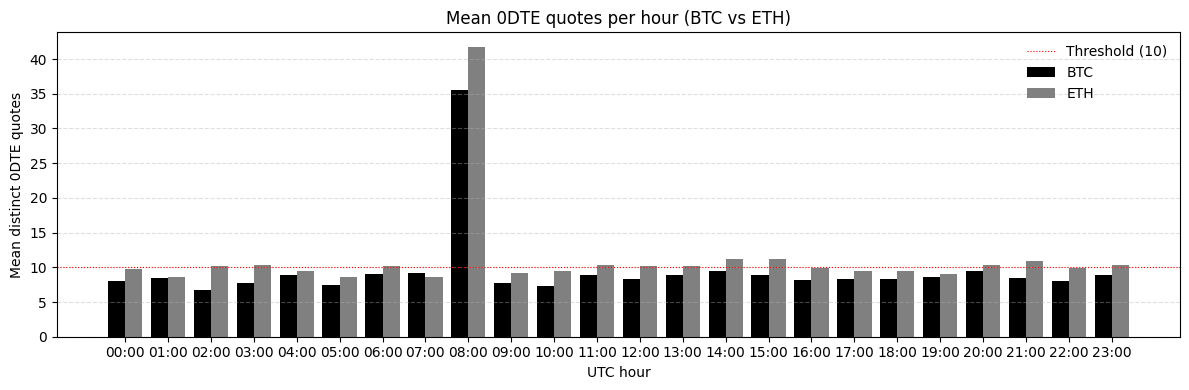

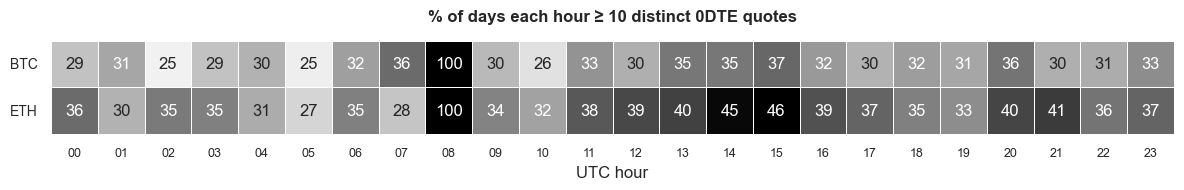

In [7]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from matplotlib.patches import Rectangle

# ── CONFIG ──────────────────────────────────────────────────────────
DATA_DIR   = '/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/snapshot_data'
COINS      = ['btc', 'eth']
THRESHOLD  = 10
hours      = np.arange(24)
hour_labels = [f'{h:02d}:00' for h in hours]
colors     = {'BTC': 'black', 'ETH': 'gray'}
bar_w      = 0.4
offsets    = [-bar_w/2, bar_w/2]

mean_by_hour   = {}
pct_above10_hr = {}

# ── BUILD HOURLY STATISTICS ─────────────────────────────────────────
for coin in COINS:
    fp = os.path.join(DATA_DIR, f"{coin}_full_data_transformed.csv")
    df = pd.read_csv(fp)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    # df  = df[df['timestamp'].dt.minute == 0]           
    if df.empty:
        continue

    # timestamps already rounded to hh:00
    df['hour']      = df['timestamp'].dt.hour
    df['date']      = df['timestamp'].dt.date

    # Get DTE and round to integer days
    df[['coin', 'exp_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)              
    expiry_date = pd.to_datetime(df['exp_raw'], format='%d%b%y', errors='coerce')
    df['expiry'] = (expiry_date + pd.Timedelta(hours=8)).dt.tz_localize('UTC')     
    df['DTE_raw'] = (df['expiry'] - df['timestamp']) 
    df['DTE'] = np.floor(df['DTE_raw'] / pd.Timedelta(days=1)).astype('Int64') 

    mask_08 = df['timestamp'].dt.hour == 8
    print(df.loc[mask_08, 'DTE'].value_counts().head())  
    
    df = df[df['DTE'] < 1]   

    # pivot: rows = date, cols = hour, cells = distinct symbols
    pivot = df.groupby(['date', 'hour'])['symbol'].nunique().unstack(fill_value=0)

    # (1) mean distinct quotes per hour
    mean_by_hour[coin.upper()] = pivot.mean().reindex(hours, fill_value=0).values

    # (2) % of days >= threshold
    pct = (pivot >= THRESHOLD).sum(axis=0) / pivot.shape[0] * 100
    pct_above10_hr[coin.upper()] = pct.reindex(hours, fill_value=0).values

# PLOT 1 — BAR CHART 
plt.figure(figsize=(12, 4))
for i, coin in enumerate(['BTC', 'ETH']):
    plt.bar(hours + offsets[i], mean_by_hour[coin], width=bar_w,
            color=colors[coin], label=coin)
plt.axhline(THRESHOLD, color='red', ls=':', lw=0.8, label=f'Threshold ({THRESHOLD})')
plt.xticks(hours, hour_labels)
plt.xlabel('UTC hour')
plt.ylabel('Mean distinct 0DTE quotes')
plt.title('Mean 0DTE quotes per hour (BTC vs ETH)', fontsize=12)
plt.grid(axis='y', ls='--', alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ── PLOT 2 — HEAT‑MAP ──────────────────────────────────────────────
sns.set_theme(style='white')
heat_df = pd.DataFrame(
    pct_above10_hr,
    index=[f'{h:02d}' for h in hours]   # columns = 00‑23
).T                                     # rows = BTC / ETH

fig, ax = plt.subplots(figsize=(12, 3.5))
cmap = sns.light_palette("#000000", as_cmap=True)
vmax = np.nanmax(heat_df.replace(100, np.nan).values)  # avoid 100% clipping

sns.heatmap(
    heat_df, annot=True, fmt='.0f',
    cmap=cmap, vmin=heat_df.values.min(), vmax=vmax,
    linewidths=.5, linecolor='white',
    cbar=False, square=True, ax=ax
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=9)
ax.set_yticklabels(['BTC', 'ETH'], rotation=0, fontsize=10)
ax.set_xlabel('UTC hour'); ax.set_ylabel('')
ax.set_title('% of days each hour ≥ 10 distinct 0DTE quotes', fontsize=12, pad=14, fontweight='bold')


plt.tight_layout()
plt.show()


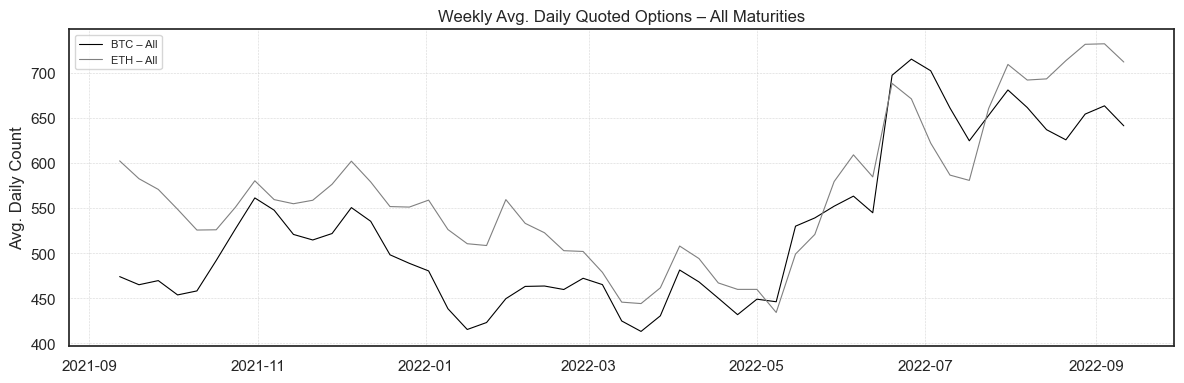

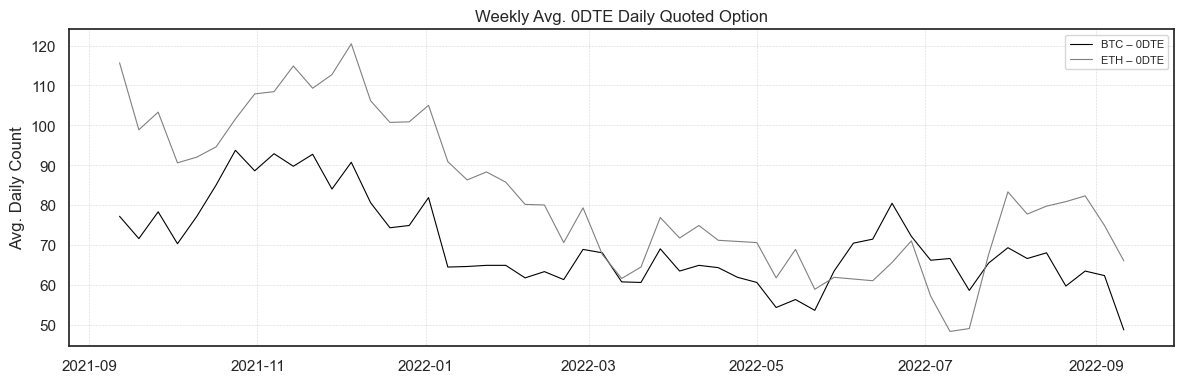

In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

UTC_HOUR = 3
COINS    = ['btc', 'eth']
colors   = {'BTC': 'black', 'ETH': 'gray'}

weekly_all  = {}
weekly_0dte = {}

for coin in COINS:
    fp = os.path.join(DATA_DIR, f'{coin.upper()}_full_data_transformed.csv')
    df = pd.read_csv(fp)

    # ── timestamp & calendar date ─────────────────────────────────────────
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df['date']      = df['timestamp'].dt.floor('D').dt.tz_localize(None)  # strip tz for resample

    # ── expiry & DTE (float days) ────────────────────────────────────────
    exp_raw = df['symbol'].str.split('-').str[1]
    expiry  = (pd.to_datetime(exp_raw, format='%d%b%y', errors='coerce') +
               pd.Timedelta(hours=8)).dt.tz_localize('UTC')
    df['DTE'] = (expiry - df['timestamp']) / pd.Timedelta(days=1)

    # ── ALL maturities: daily → weekly mean ──────────────────────────────
    daily_all = df.groupby('date')['symbol'].nunique()
    daily_all.index = pd.to_datetime(daily_all.index)          # ensure DateTimeIndex
    weekly_all[coin.upper()] = daily_all.resample('W').mean()

    # ── 0‑DTE only: daily → weekly mean ─────────────────────────────────
    df_0dte = df[df['DTE'] < 1]
    daily_0dte = df_0dte.groupby('date')['symbol'].nunique()
    daily_0dte.index = pd.to_datetime(daily_0dte.index)
    weekly_0dte[coin.upper()] = daily_0dte.resample('W').mean()

# ── PLOT 1 · ALL maturities ─────────────────────────────────────────────
plt.figure(figsize=(12, 4))
for coin in ['BTC', 'ETH']:
    plt.plot(weekly_all[coin].index, weekly_all[coin].values,
             lw=0.8, color=colors[coin], label=f'{coin} – All')
plt.title('Weekly Avg. Daily Quoted Options – All Maturities')
plt.ylabel('Avg. Daily Count')
plt.grid(ls=':', lw=0.4, color='grey', alpha=0.6)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# ── PLOT 2 · 0‑DTE only ────────────────────────────────────────────────
plt.figure(figsize=(12, 4))
for coin in ['BTC', 'ETH']:
    plt.plot(weekly_0dte[coin].index, weekly_0dte[coin].values,
             lw=0.8, color=colors[coin], label=f'{coin} – 0DTE')
plt.title(f'Weekly Avg. 0DTE Daily Quoted Option')
plt.ylabel('Avg. Daily Count')
plt.grid(ls=':', lw=0.4, color='grey', alpha=0.6)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


BTC: 365 out of 365 days had more than 10 contracts at 08:00 UTC → 100.00%
Median: 30.0, Mean: 35.57, Std: 13.79, Min: 20, Max: 98


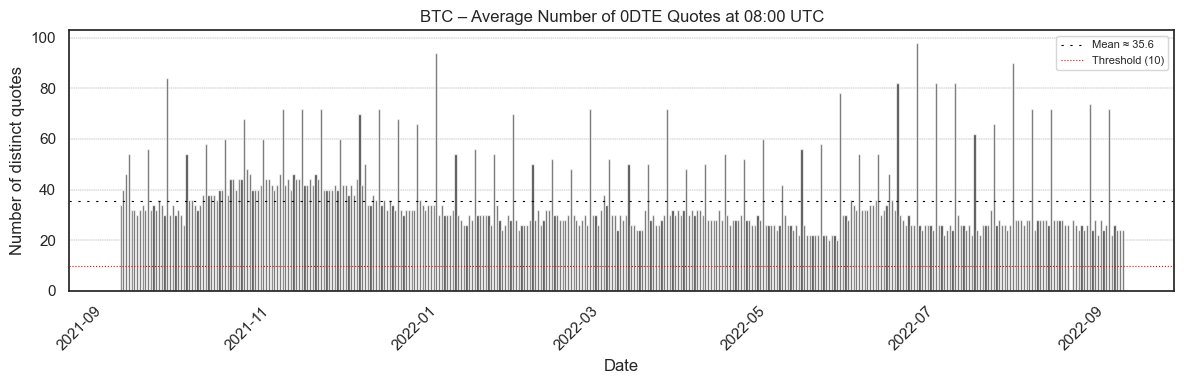

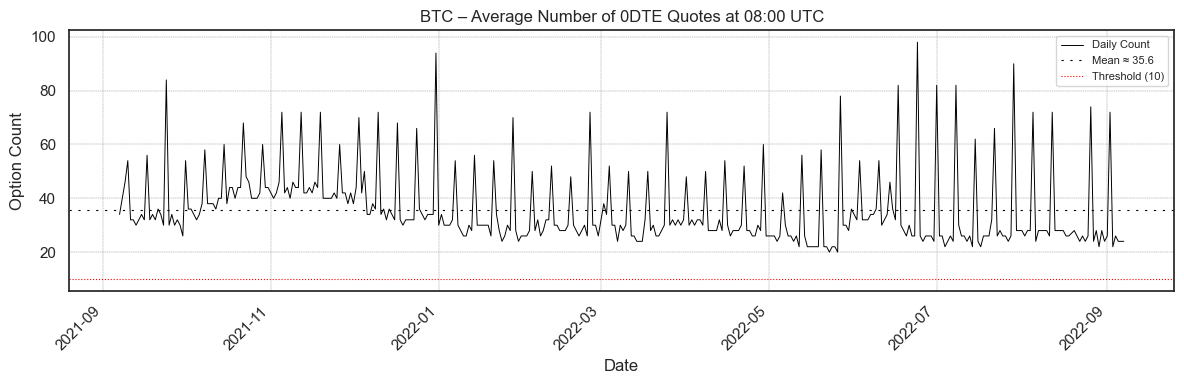

ETH: 365 out of 365 days had more than 10 contracts at 08:00 UTC → 100.00%
Median: 38.0, Mean: 41.75, Std: 14.30, Min: 20, Max: 110


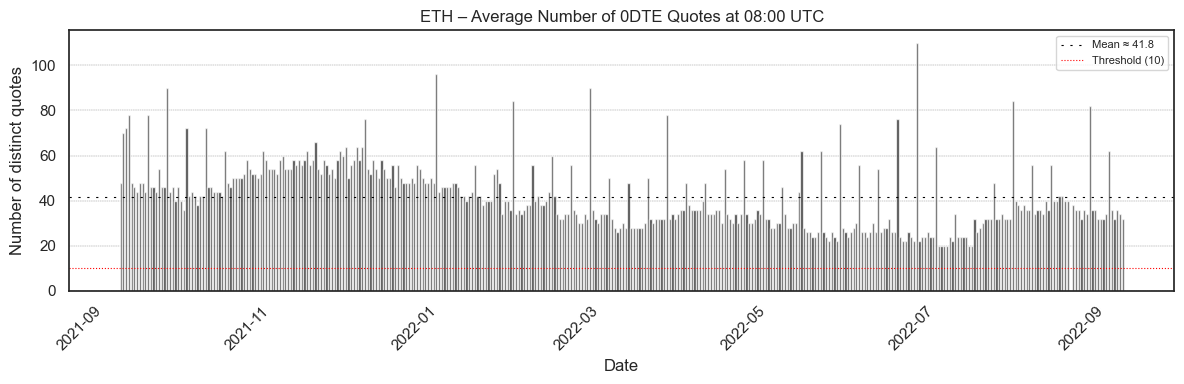

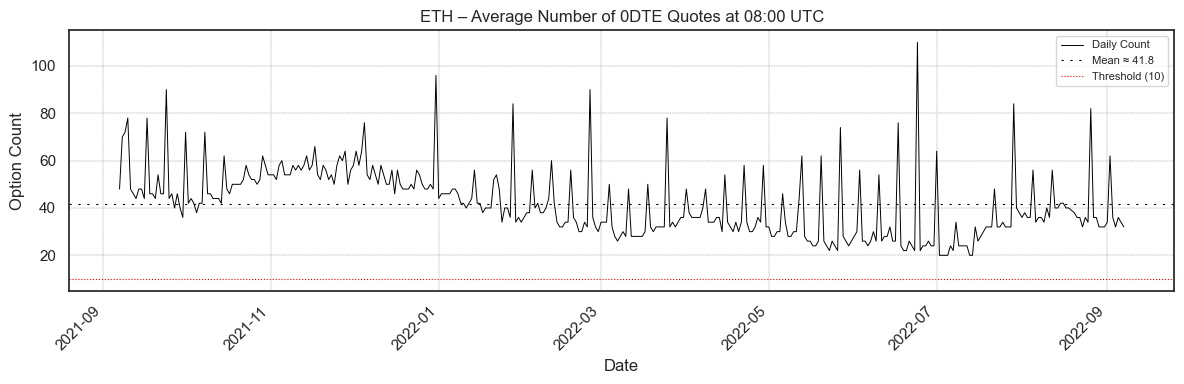

In [64]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

UTC_HOUR   = 8
THRESHOLD  = 10

for coin in COINS:
    fp = os.path.join(DATA_DIR, f'{coin.upper()}_full_data_transformed.csv')
    df = pd.read_csv(fp)

    # ── timestamps & filter ────────────────────────────────────────────────
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df = df[(df['timestamp'].dt.hour == UTC_HOUR) &
            (df['timestamp'].dt.minute == 0)].copy()

    df[['coin', 'exp_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)
    expiry_dt = pd.to_datetime(df['exp_raw'], format='%d%b%y', errors='coerce')
    df['expiry'] = expiry_dt + pd.Timedelta(hours=8)   # expiry at 08:00 UTC (tz-naive OK)
    df['expiry'] = df['expiry'].dt.tz_localize('UTC')  # force to UTC

    secs = (df['expiry'] - df['timestamp']).dt.total_seconds()
    df['DTE'] = np.floor(secs / 86_400).astype('Int64')
    df = df[df['DTE'] == 0]

    if df.empty:
        print(f"⚠ No data for {coin.upper()} at {UTC_HOUR:02d}:00 UTC")
        continue

    df['date'] = df['timestamp'].dt.date
    option_counts = df.groupby('date')['symbol'].nunique()

    # ── basic stats ─────────────────────────────────────────────────────────
    mean_val   = option_counts.mean()
    median_val = option_counts.median()
    std_val    = option_counts.std()
    min_val    = option_counts.min()
    max_val    = option_counts.max()

    days_above = (option_counts >= THRESHOLD).sum()
    print(f"{coin.upper()}: {days_above} out of {len(option_counts)} days "
          f"had more than {THRESHOLD} contracts at {UTC_HOUR:02d}:00 UTC → {days_above/len(option_counts):.2%}")
    print(f"Median: {median_val}, Mean: {mean_val:.2f}, Std: {std_val:.2f}, Min: {min_val}, Max: {max_val}")

    # ── BAR PLOT ────────────────────────────────────────────────────────────
    plt.figure(figsize=(12, 4))
    plt.bar(option_counts.index, option_counts.values, color='black', alpha=0.7, width=0.8)
    plt.axhline(mean_val, color='black', linestyle=(0, (2, 6)), linewidth=0.8, label=f'Mean ≈ {mean_val:.1f}')
    plt.axhline(THRESHOLD, color='red', linestyle=':', linewidth=0.8, label=f'Threshold ({THRESHOLD})')
    plt.title(f'{coin.upper()} – Average Number of 0DTE Quotes at {UTC_HOUR:02d}:00 UTC')
    plt.ylabel('Number of distinct quotes')
    plt.xlabel('Date')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', linewidth=0.3, color='gray')
    plt.legend(fontsize=8, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Line plot
    option_counts.plot(figsize=(12, 4), color='black', linewidth=0.7, label='Daily Count')

    plt.axhline(mean_val, color='black', linestyle=(0, (2, 6)), linewidth=0.8, label=f'Mean ≈ {mean_val:.1f}')
    plt.axhline(THRESHOLD, color='red', linestyle=':', linewidth=0.8, label=f'Threshold ({THRESHOLD})')
    plt.title(f'{coin.upper()} – Average Number of 0DTE Quotes at {UTC_HOUR:02d}:00 UTC')
    plt.ylabel('Option Count')
    plt.xlabel('Date')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', linewidth=0.3, color='gray', alpha=1)
    plt.legend(fontsize=8, loc='upper right')
    plt.tight_layout()
    plt.show()


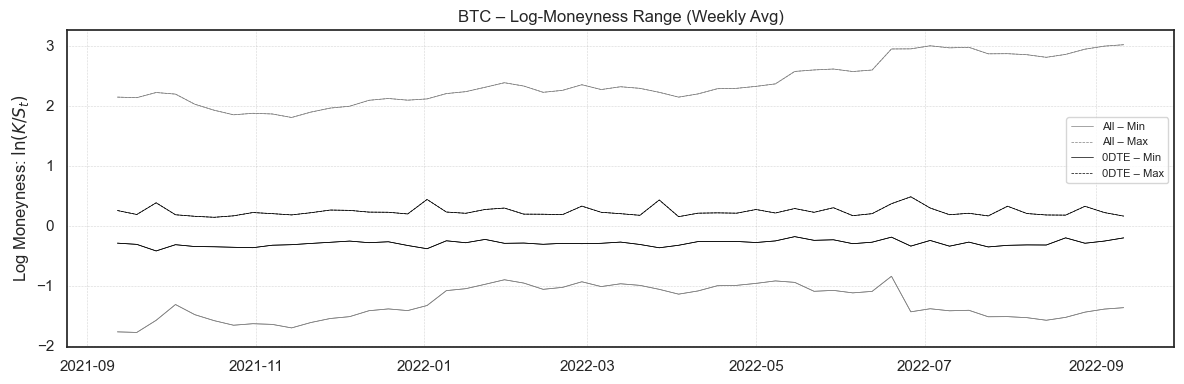

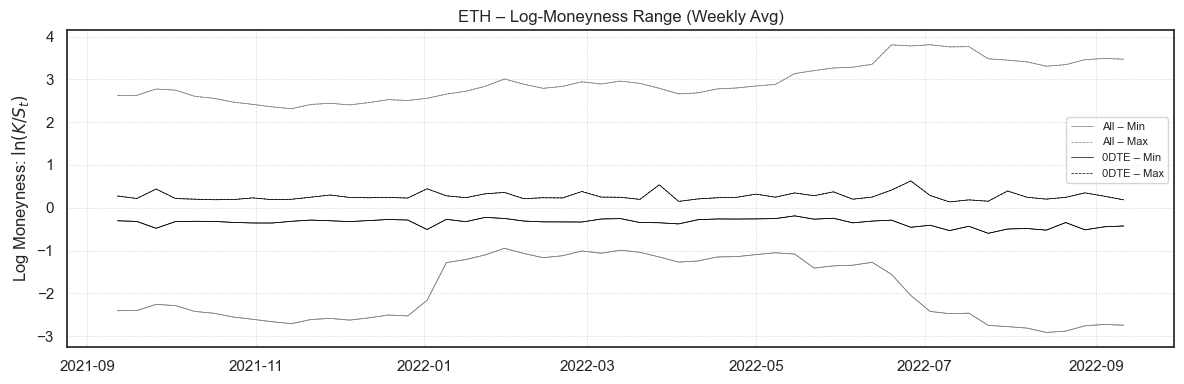

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

UTC_HOUR = 8

for coin in COINS:
    full_path = os.path.join(DATA_DIR, f'{coin.upper()}_full_data_transformed.csv')

    df = pd.read_csv(full_path)
    df['F'] = df['spot']
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)

    # ─── derive expiry timestamp ───────────────────────────────
    exp_raw = df['symbol'].str.split('-').str[1]
    expiry = (pd.to_datetime(exp_raw, format='%d%b%y', errors='coerce') +
              pd.Timedelta(hours=8)).dt.tz_localize('UTC')
    df['expiry'] = expiry

    # ─── snapshot at 03:00 UTC ────────────────────────────────
    snap_all = df[(df['timestamp'].dt.hour == UTC_HOUR) &
                  (df['timestamp'].dt.minute == 0)].copy()
    if snap_all.empty:
        print(f'No 03:00 UTC quotes for {coin.upper()}')
        continue
    snap_all['date'] = snap_all['timestamp'].dt.normalize()
    snap_all['std_mny'] = np.log(snap_all['strike'] / snap_all['F'])

    # ─── 0‑DTE filter ──────────────────────────────────────────
    dt_days = (snap_all['expiry'] - snap_all['timestamp']) / pd.Timedelta(days=1)
    snap_0dte = snap_all[(dt_days >= 0) & (dt_days < 1)].copy()

    # ─── compute daily p01/p99 for both sets ───────────────────
    def summarise(df_):
        daily = (df_.groupby('date')['std_mny']
                    .agg(['min', 'max'])
                    .dropna())
        return daily.resample('W').mean()   # or 'W-FRI'

    weekly_all  = summarise(snap_all)
    weekly_0dte = summarise(snap_0dte)

    plt.figure(figsize=(12, 4))

    # All quotes (gray)
    plt.plot(weekly_all.index,  weekly_all['min'], '-', color='gray',   label='All – Min', linewidth=0.5)
    plt.plot(weekly_all.index,  weekly_all['max'], '--', color='gray',   label='All – Max', linewidth=0.5)

    # 0DTE quotes (black + thicker)
    plt.plot(weekly_0dte.index, weekly_0dte['min'], '-', color='black', label='0DTE – Min', linewidth=0.5)
    plt.plot(weekly_0dte.index, weekly_0dte['max'], '--', color='black', label='0DTE – Max', linewidth=0.5)

    # Optional: add small markers for readability
    plt.plot(weekly_0dte.index, weekly_0dte['min'], color='black', linewidth=0.5)
    plt.plot(weekly_0dte.index, weekly_0dte['max'], color='black', linewidth=0.5)
    plt.plot(weekly_all.index,  weekly_all['min'], color='gray', linewidth=0.5)
    plt.plot(weekly_all.index,  weekly_all['max'], color='gray', linewidth=0.5)

    plt.title(f'{coin.upper()} – Log-Moneyness Range (Weekly Avg)')
    plt.ylabel(r'Log Moneyness: $\ln(K / S_t)$')    
    plt.grid(ls=':', lw=0.4, color='grey', alpha=.6)
    plt.legend(fontsize=8, loc='lower right', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()



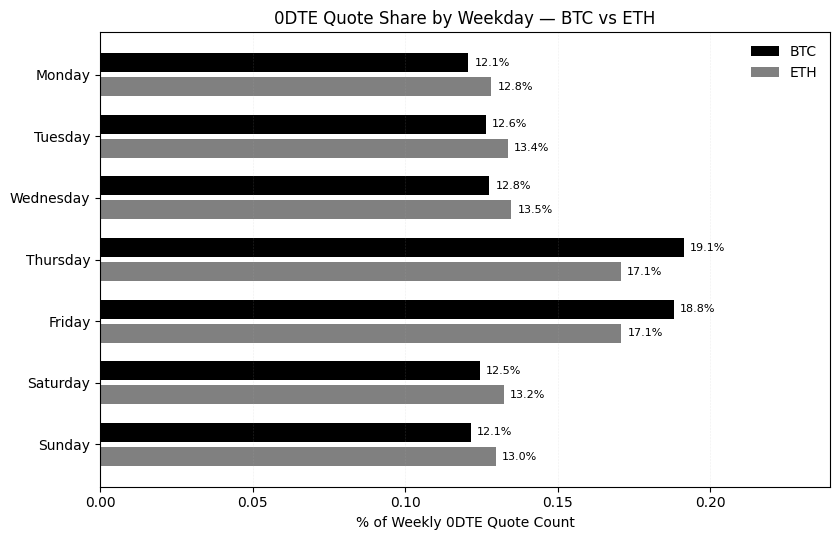

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# config 
all_csv_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.csv')])
COLORS = {'BTC': 'black', 'ETH': 'gray'}
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# aggregate 0DTE volumes by weekday 
shares_per_coin = {}

for coin in COINS:
    coin = coin.lower()
    weekday_counts = {day: 0 for day in DAYS}

    for file in all_csv_files:
        df = pd.read_csv(os.path.join(DATA_DIR, file))

        # ─── basic parsing ───────────────────────────────
        df[['coin', 'expiry_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)
        df['coin'] = df['coin'].str.lower()
        df = df[df['coin'] == coin]

        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
        df['expiry'] = pd.to_datetime(df['expiry_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)
        df['expiry'] = df['expiry'].dt.tz_localize('UTC')

        df['DTE'] = np.floor((df['expiry'] - df['timestamp']) / pd.Timedelta(days=1)).astype(int)
        df = df[df['DTE'] == 0].copy()

        df['day_of_week'] = df['timestamp'].dt.day_name()

        # ─── count distinct option symbols per weekday ───
        daily_counts = df.groupby('day_of_week')['symbol'].nunique()
        for day in DAYS:
            weekday_counts[day] += daily_counts.get(day, 0)

    # ─── normalize to percentage share ──────────────────
    total_count = sum(weekday_counts.values())
    weekday_share = {day: (weekday_counts[day] / total_count) if total_count > 0 else 0 for day in DAYS}
    shares_per_coin[coin.upper()] = weekday_share

# ─── prepare for horizontal bar plot ─────────────────────────
btc_vals = [shares_per_coin['BTC'][day] for day in DAYS]
eth_vals = [shares_per_coin['ETH'][day] for day in DAYS]

y_pos = np.arange(len(DAYS))
bar_h = 0.35
gap = 0.04
btc_y = y_pos - bar_h / 2 - gap / 2
eth_y = y_pos + bar_h / 2 + gap / 2

# ─── plot ────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8.5, 5.5))
bars_btc = ax.barh(btc_y, btc_vals, height=bar_h-gap, color=COLORS['BTC'], label='BTC')
bars_eth = ax.barh(eth_y, eth_vals, height=bar_h-gap, color=COLORS['ETH'], label='ETH')

# Annotate bars
for bars in [bars_btc, bars_eth]:
    for bar in bars:
        w = bar.get_width()
        ax.text(w + 0.002, bar.get_y() + bar.get_height()/2,
                f'{w*100:.1f}%', va='center', fontsize=8)

# ─── formatting ──────────────────────────────────────────────
ax.set_yticks(y_pos)
ax.set_yticklabels(DAYS)
ax.set_xlabel('% of Weekly 0DTE Quote Count')
ax.set_xlim(0, max(btc_vals + eth_vals) * 1.25)
ax.set_title('0DTE Quote Share by Weekday — BTC vs ETH')
ax.grid(True, axis='x', linestyle=':', linewidth=0.4, alpha=0.4)
ax.legend(loc='upper right', frameon=False)
ax.invert_yaxis()

plt.tight_layout()
plt.show()
